In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [2]:
houses_train_cleaned = pd.read_csv('./datasets/cleaned/house_train_cleaned.csv')
houses_test_cleaned = pd.read_csv('./datasets/cleaned/house_test_cleaned.csv')

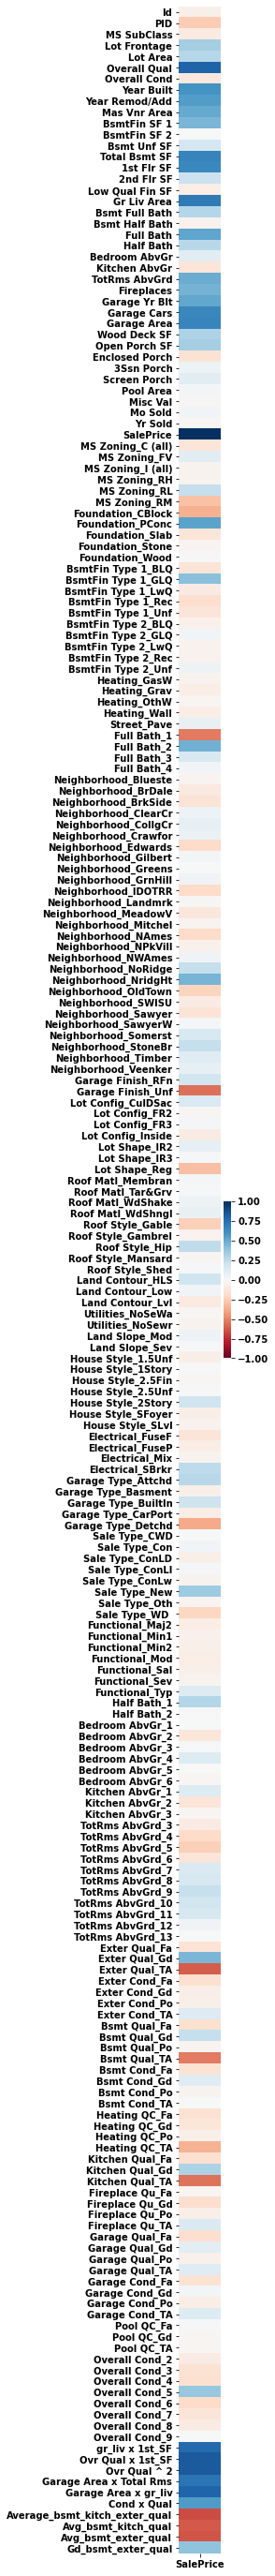

In [3]:
plt.figure(figsize=(1, 50))
sns.heatmap(houses_train_cleaned.corr()[['SalePrice']], vmin=-1, vmax=1, cmap='RdBu');

In [4]:
# random_feature_thresh_test(houses_train_cleaned, 'SalePrice', features_all, 1.5)

In [94]:
# mean_corr = houses_train_cleaned.corr()['SalePrice'].mean()
features = get_features(houses_train_cleaned, -1)
len(features)

226

In [95]:
X_real_test = houses_test_cleaned[[col for col in features if col in houses_test_cleaned]]
X_real_test.shape

(878, 208)

## Prepping model for Kaggle Submission

In [96]:
# Garage Cars was type int64 in houses_test_cleaned, was type float in houses_train_cleaned_pol_scale
houses_test_cleaned['Garage Cars'] = houses_test_cleaned['Garage Cars'].apply(lambda x: float(x))

In [97]:
houses_test_cleaned.shape

(878, 258)

## Testing!!

### Splitting the Data

In [98]:
outlier_indices = [1796, 125]
X = houses_train_cleaned[[col for col in features if col in houses_test_cleaned]].drop(outlier_indices)
y = houses_train_cleaned['SalePrice'].drop(outlier_indices)
X.shape

(2032, 208)

In [99]:
model = sm.OLS(y, X).fit()

In [100]:
significant_features = list(model.pvalues[model.pvalues < 0.04].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [101]:
significant_features

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Screen Porch',
 'MS Zoning_FV',
 'MS Zoning_RH',
 'MS Zoning_RL',
 'MS Zoning_RM',
 'BsmtFin Type 1_GLQ',
 'BsmtFin Type 2_LwQ',
 'BsmtFin Type 2_Rec',
 'Heating_Grav',
 'Neighborhood_CollgCr',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_OldTown',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Lot Config_CulDSac',
 'Lot Config_FR3',
 'Roof Matl_WdShake',
 'Land Contour_HLS',
 'House Style_2.5Fin',
 'Garage Type_Attchd',
 'Garage Type_BuiltIn',
 'Garage Type_Detchd',
 'Sale Type_Con',
 'Sale Type_New',
 'Sale Type_Oth',
 'Sale Type_WD ',
 

In [102]:
X = houses_train_cleaned[[col for col in significant_features if col in houses_test_cleaned]].drop(outlier_indices)

In [103]:
X_train, X_test, y_train, y_test = get_cval_score_mse(X, y)

The Cross Validation Score is: [0.92483592 0.917744   0.92898589 0.9265485  0.92295039]
The R2 score on testing data is: 0.9263203429771711
The MSE is 19276.52358843629


In [104]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [105]:
cross_val_score(lr, X_train, y_train)

array([0.92483592, 0.917744  , 0.92898589, 0.9265485 , 0.92295039])

In [106]:
y_pred = lr.predict(X_test)

In [107]:
lr.score(X_test, y_test)

0.9263203429771711

In [108]:
metrics.mean_squared_error(y_test, y_pred, squared=False)

19276.52358843629

In [109]:
resids = y_test - y_pred

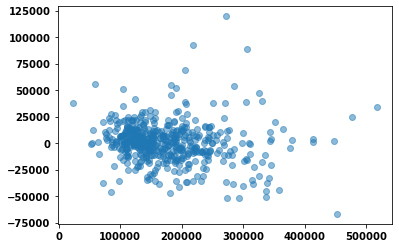

In [110]:
plt.scatter(y_pred, resids, alpha=0.5)

In [111]:
X.shape

(2032, 74)

In [112]:
sc = StandardScaler()

In [113]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [114]:
ridge = Ridge(alpha=100)

In [115]:
ridge.fit(X_train_sc, y_train)

Ridge(alpha=100)

In [116]:
print(f'Train Ridge: {ridge.score(X_train_sc, y_train)}')
print(f'Test Ridge: {ridge.score(X_test_sc, y_test)}')

Train Ridge: 0.9314573279103063
Test Ridge: 0.9240147388568373


## Training model on all data

In [117]:
lr.fit(X, y)

LinearRegression()

In [118]:
X_real_test = houses_test_cleaned[[col for col in significant_features if col in houses_test_cleaned]]
X_real_test.shape

(878, 74)

In [119]:
X_real_test_sc = sc.fit_transform(X_real_test)

In [120]:
len(X_real_test)

878

In [121]:
r_alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV( 
    alphas=r_alphas,
    scoring='r2',
    cv=5
)

# Fit model using best ridge alpha!
ridge_cv.fit(X_train_sc, y_train);

In [122]:
ridge_cv.score(X_test_sc, y_test)

0.9207495419041912

In [123]:
houses_test_cleaned['SalePrice'] = ridge_cv.predict(X_real_test_sc)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,180865.713911
std,850.838263,75573.594204
min,2.000000,12895.140328
25%,692.250000,130145.184660
50%,1433.000000,161637.894092
75%,2197.500000,214501.675231
max,2928.000000,602003.624944


In [124]:
submission.to_csv('./submissions/test35.csv', index=False)